In [ ]:
import os.path

from ml.scripts.precompute import backdrop

""" notes:

do some more eda to make sure computing will be don properly
then create mappings

id
title (ord) (encode) - title of movie
vote_average (ord) ()- average rating of movie
vote_count (ord) (log) (normalize)- number of votes of movie
release_date // parse year (ord) (normalize)
revenue (ord) (log) (normalize)
runtime (ord) (log) (normalize)
back_drop_path (ord) (get image form link) (encode)
budget (ord) (log) (normalize)
overview (ord) (encode)
popularity (ord) (log) (normalize)
poster_path (ord) (encode)
tagline (ord) (encode)
genres (cat) (one hot encoded)
keywords (multi-hot encoded) or (use pretrained word2vec then pool)
""";

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import PowerTransformer

In [3]:
df = pd.read_csv(os.path.abspath("../data/processed/movie_dataset_cleaned.csv"))

In [4]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['release_year'] = df['release_date'].dt.year

month = df['release_date'].dt.month
df['month_sin'] = np.sin(2 * np.pi * month / 12)
df['month_cos'] = np.cos(2 * np.pi * month / 12)
df.drop(['release_date'], axis=1, inplace=True)

In [5]:
df.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'revenue', 'runtime',
       'backdrop_path', 'budget', 'overview', 'popularity', 'poster_path',
       'tagline', 'genres', 'keywords', 'release_year', 'month_sin',
       'month_cos'],
      dtype='object')

In [29]:
# verifying log logic (final verdicts)
''' standard scaler for norms
vote_count (ord) (log) (normalize)- number of votes of movie
runtime (ord) (yj) (normalize)
vote_average (ord) (normalize)
popularity (ord) (log) (normalize)


revenue (ord) (log) (normalize) REMOVING
budget (ord) (yj) (normalize) REMOVING
''';

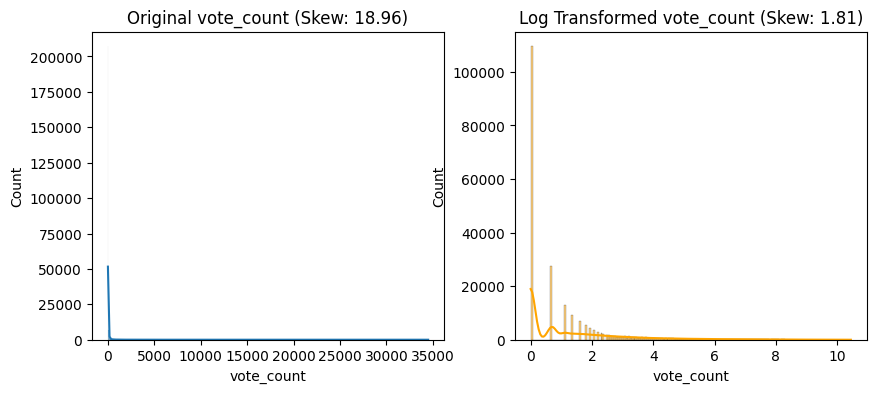

Verdict for vote_count: USE LOG 


C:\Users\ds3\Desktop\mth4370_group_project\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


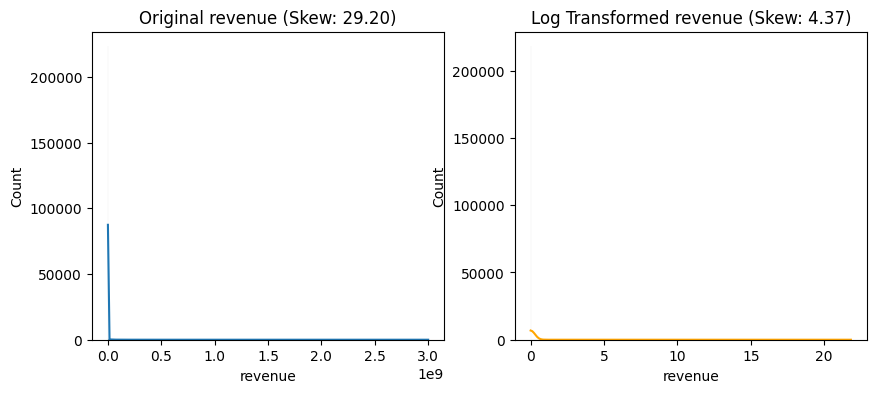

Verdict for revenue: USE LOG 


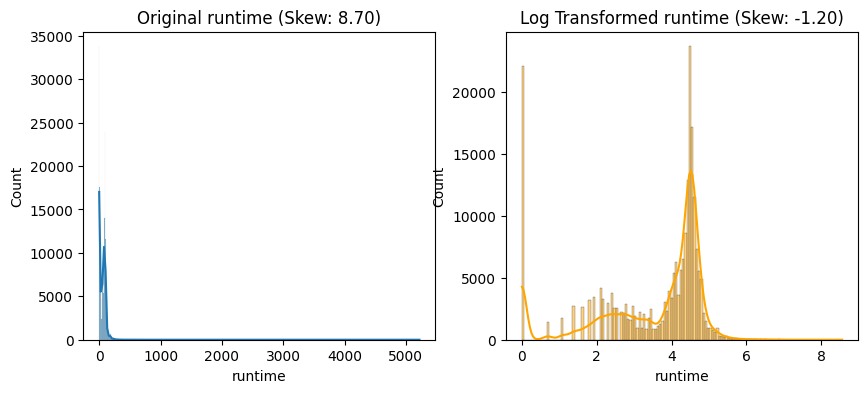

Verdict for runtime: USE LOG 


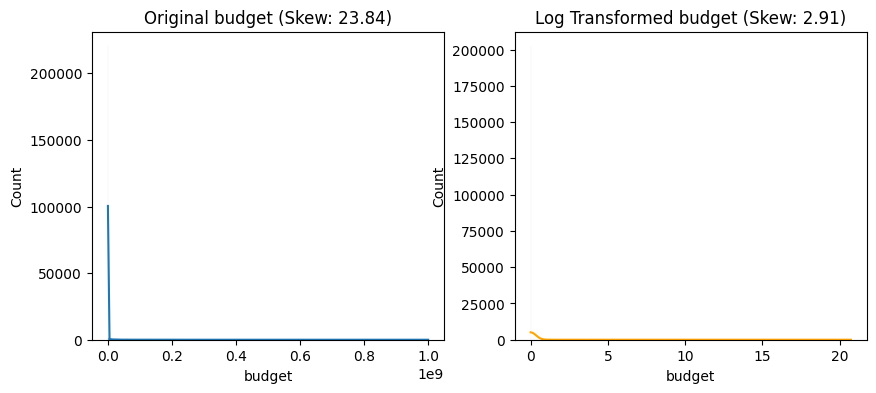

Verdict for budget: USE LOG 


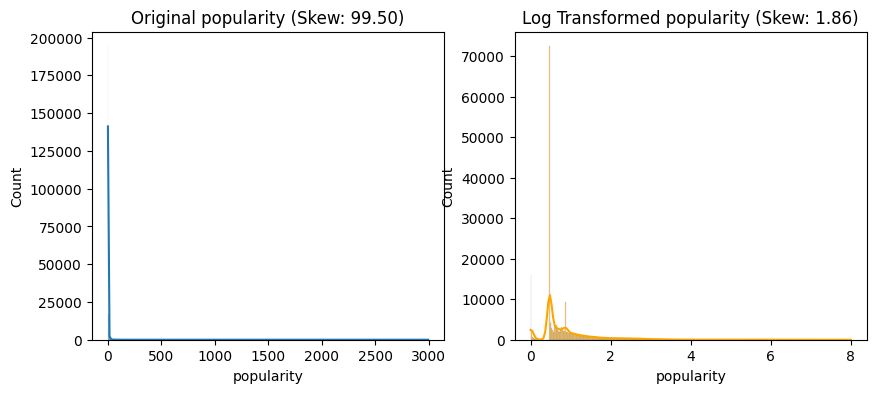

Verdict for popularity: USE LOG 


In [30]:
features = ['vote_count', 'revenue', 'runtime', 'budget', 'popularity']

for feat in features:
    skew = df[feat].skew()

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Original
    sns.histplot(df[feat], ax=ax[0], kde=True)
    ax[0].set_title(f"Original {feat} (Skew: {skew:.2f})")

    # Log Transformed (using log1p to be safe)
    log_feat = np.log1p(df[feat])
    new_skew = log_feat.skew()
    sns.histplot(log_feat, ax=ax[1], kde=True, color='orange')
    ax[1].set_title(f"Log Transformed {feat} (Skew: {new_skew:.2f})")

    plt.show()

    # Decision Logic
    if skew > 1:
        print(f"Verdict for {feat}: USE LOG ")

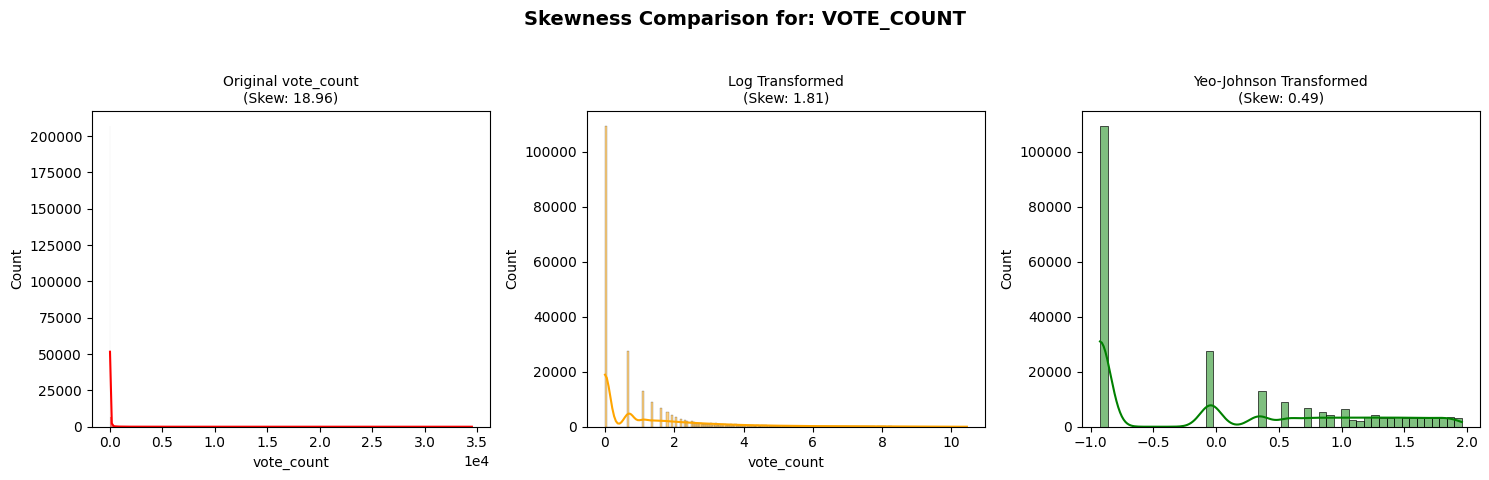

C:\Users\ds3\Desktop\mth4370_group_project\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


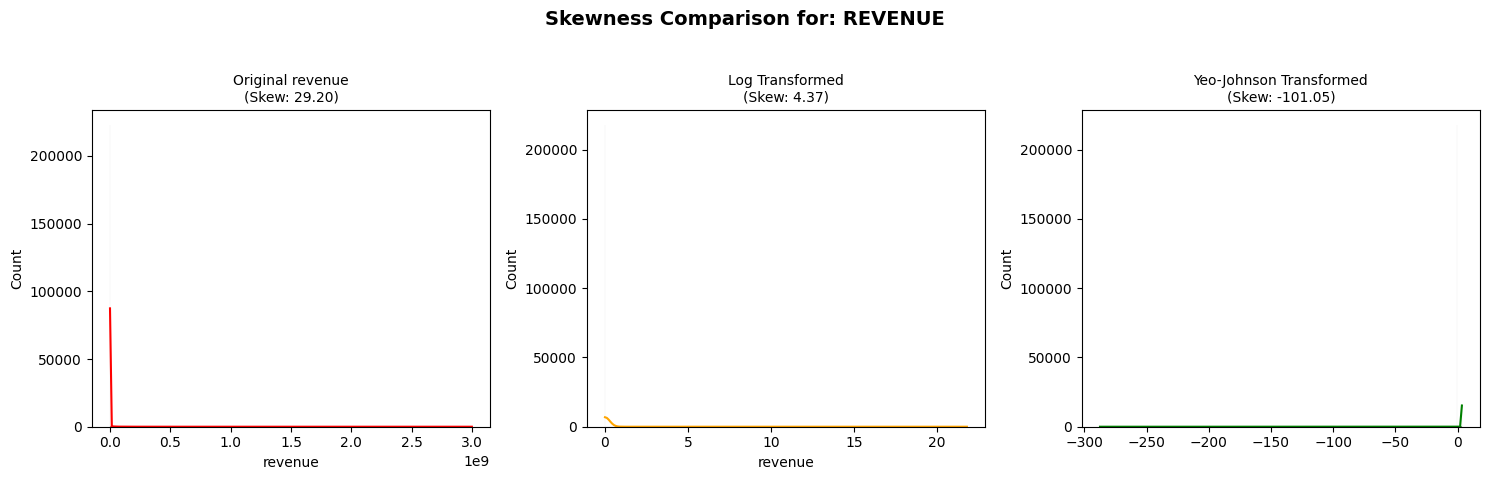

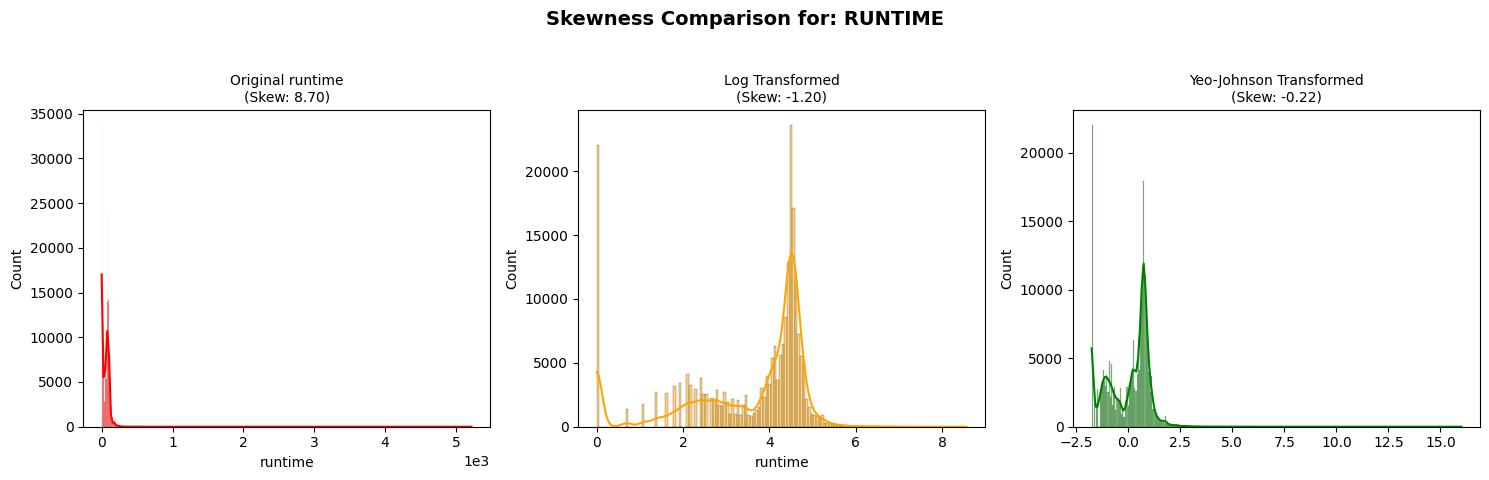

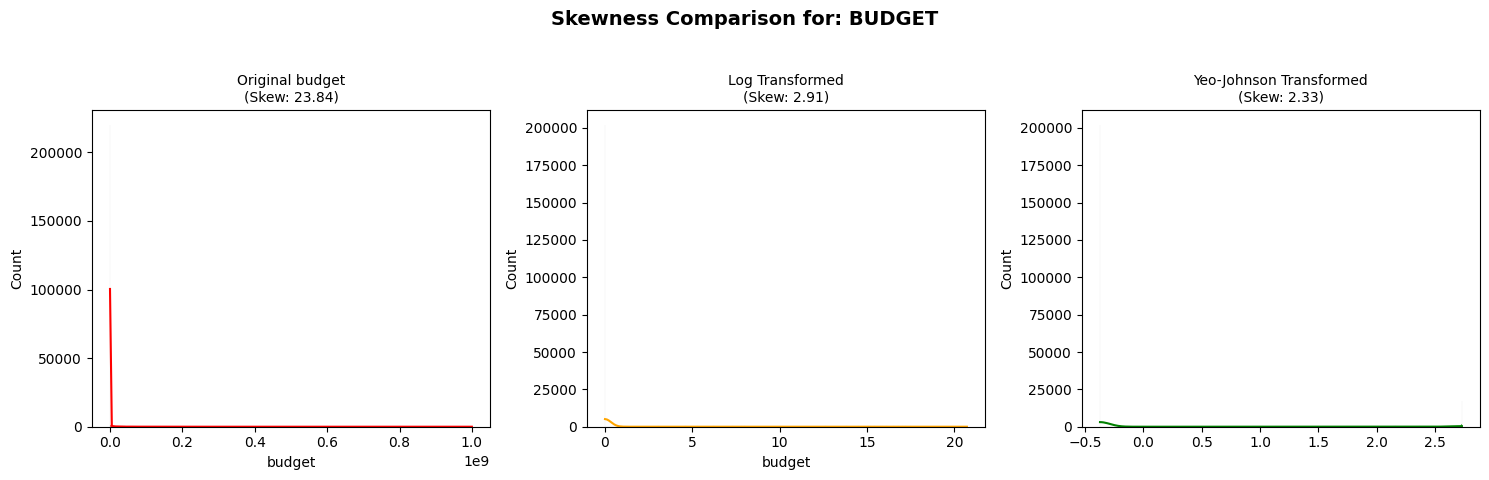

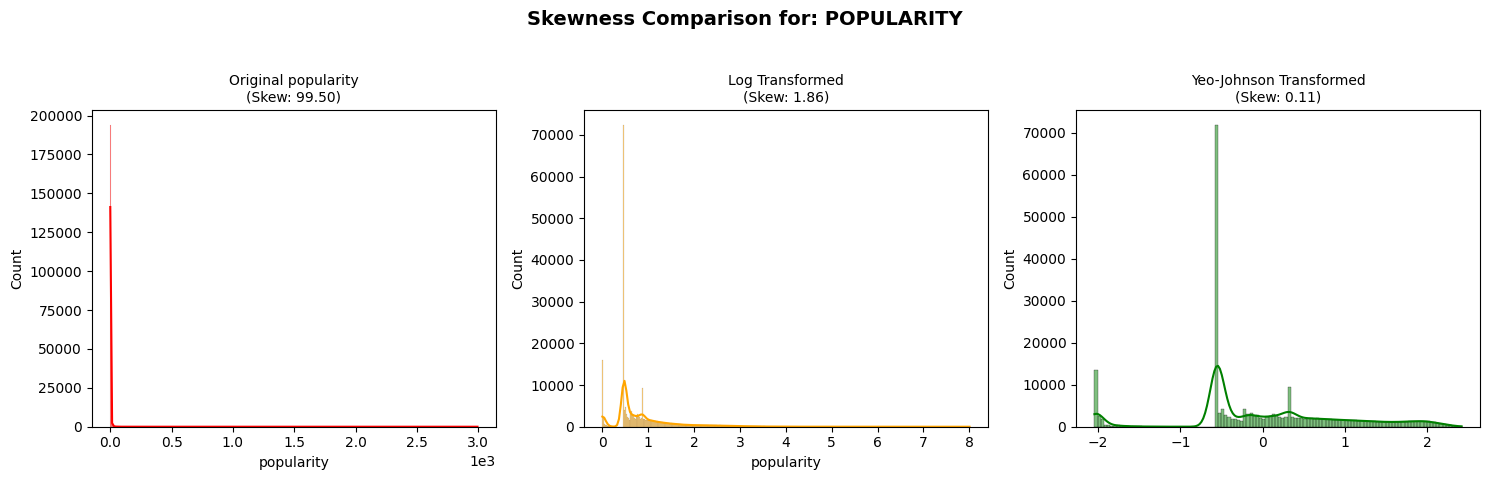

In [48]:
features = ['vote_count', 'revenue', 'runtime', 'budget', 'popularity']

for feat in features:
    yj_transformer = PowerTransformer(method='yeo-johnson')

    raw_data = df[feat].values.reshape(-1, 1)

    log_data = np.log1p(df[feat])
    yj_data = yj_transformer.fit_transform(raw_data).flatten()

    # --- Calculate Skewness ---
    skew_original = pd.Series(df[feat]).skew()
    skew_log = pd.Series(log_data).skew()
    skew_yj = pd.Series(yj_data).skew()

    # --- Plotting (3 Panels) ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Original Data
    sns.histplot(df[feat], ax=axes[0], kde=True, color='red')
    axes[0].set_title(f"Original {feat}\n(Skew: {skew_original:.2f})", fontsize=10)
    axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    # 2. Log Transformed
    sns.histplot(log_data, ax=axes[1], kde=True, color='orange')
    axes[1].set_title(f"Log Transformed\n(Skew: {skew_log:.2f})", fontsize=10)

    # 3. Yeo-Johnson Transformed
    sns.histplot(yj_data, ax=axes[2], kde=True, color='green')
    axes[2].set_title(f"Yeo-Johnson Transformed\n(Skew: {skew_yj:.2f})", fontsize=10)

    plt.suptitle(f"Skewness Comparison for: {feat.upper()}", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    plt.show()

Generating 4-way comparison plots (Original, Log, Box-Cox, Yeo-Johnson)...


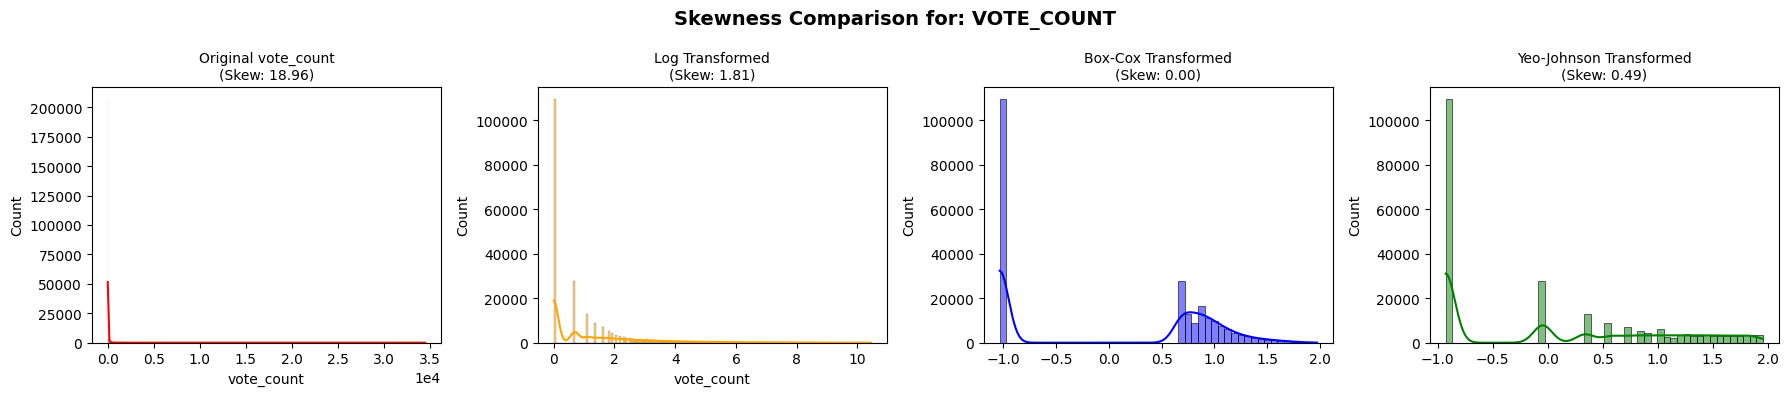

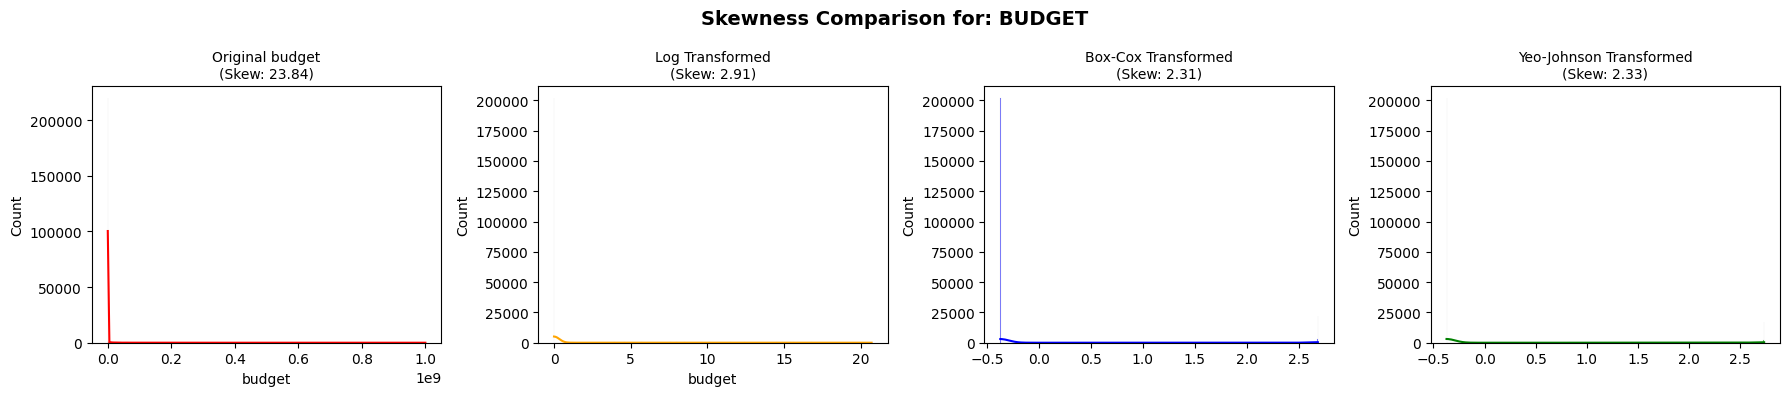

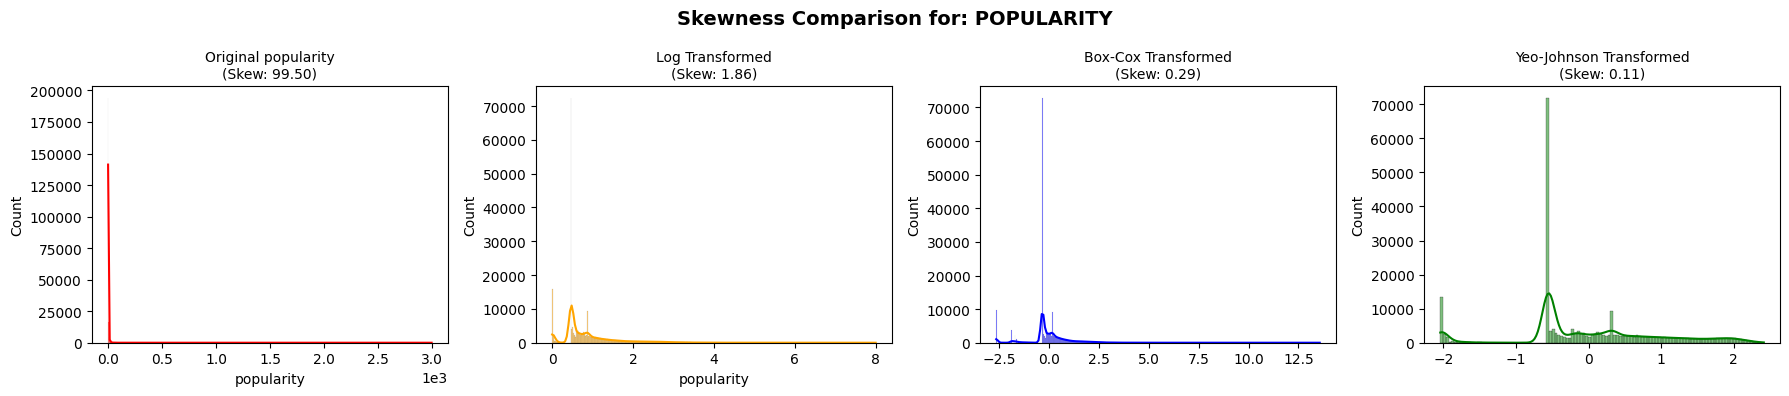

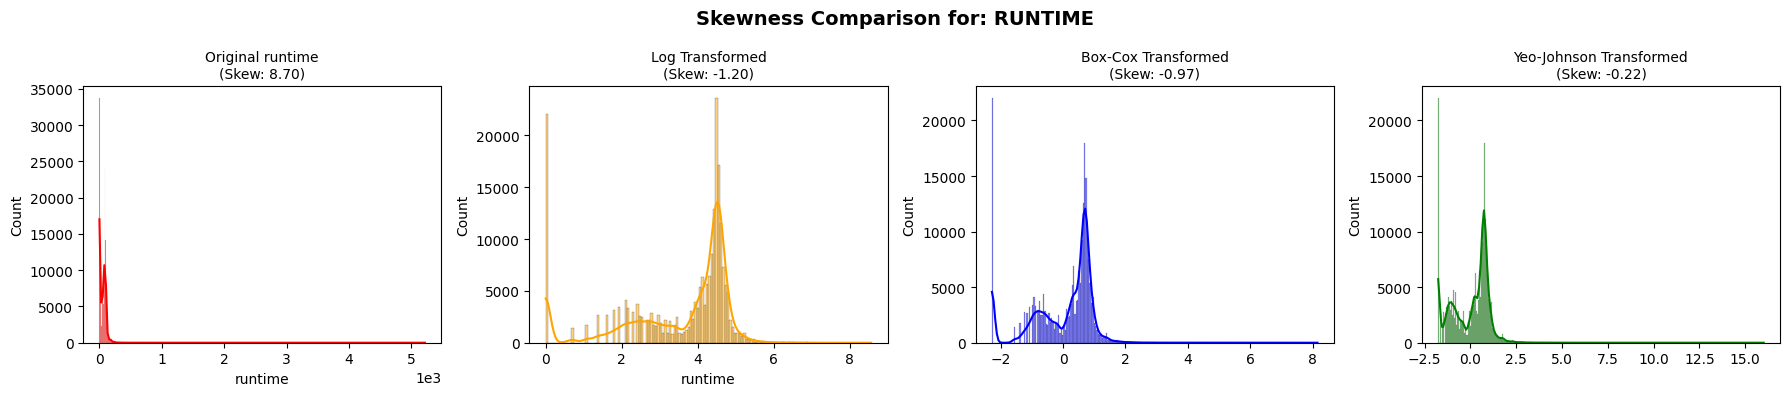


Code finished running.


In [36]:
features = ['vote_count', 'budget', 'popularity', 'runtime']

bc_transformer = PowerTransformer(method='box-cox')
yj_transformer = PowerTransformer(method='yeo-johnson')

print("Generating 4-way comparison plots (Original, Log, Box-Cox, Yeo-Johnson)...")

for feat in features:
    raw_data = df[feat].values.reshape(-1, 1)

    log_data = np.log1p(df[feat])

    bc_data_safe = raw_data + 1e-6
    bc_data = bc_transformer.fit_transform(bc_data_safe).flatten()
    yj_data = yj_transformer.fit_transform(raw_data).flatten()

    skew_original = pd.Series(df[feat]).skew()
    skew_log = pd.Series(log_data).skew()
    skew_bc = pd.Series(bc_data).skew()
    skew_yj = pd.Series(yj_data).skew()

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    # 1. Original Data
    sns.histplot(df[feat], ax=axes[0], kde=True, color='red')
    axes[0].set_title(f"Original {feat}\n(Skew: {skew_original:.2f})", fontsize=10)
    axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    # 2. Log Transformed
    sns.histplot(log_data, ax=axes[1], kde=True, color='orange')
    axes[1].set_title(f"Log Transformed\n(Skew: {skew_log:.2f})", fontsize=10)

    # 3. Box-Cox Transformed (CORRECTED INDEX: axes[2])
    sns.histplot(bc_data, ax=axes[2], kde=True, color='blue') # Changed color for distinction
    axes[2].set_title(f"Box-Cox Transformed\n(Skew: {skew_bc:.2f})", fontsize=10)

    # 4. Yeo-Johnson Transformed (CORRECTED INDEX: axes[3])
    sns.histplot(yj_data, ax=axes[3], kde=True, color='green')
    axes[3].set_title(f"Yeo-Johnson Transformed\n(Skew: {skew_yj:.2f})", fontsize=10)

    plt.suptitle(f"Skewness Comparison for: {feat.upper()}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nCode finished running.")

In [6]:
# nulls per col
nulls_per_col = df.isnull().sum()
print(nulls_per_col)

id                    0
title                 0
vote_average          0
vote_count            0
revenue               0
runtime               0
backdrop_path    122281
budget                0
overview           7644
popularity            0
poster_path       43088
tagline          151349
genres            26826
keywords         116259
release_year      17176
month_sin         17176
month_cos         17176
dtype: int64


In [7]:
#show only cols with nulls
nulls_per_col[nulls_per_col > 0] # assume that this is natural dropout

backdrop_path    122281
overview           7644
poster_path       43088
tagline          151349
genres            26826
keywords         116259
release_year      17176
month_sin         17176
month_cos         17176
dtype: int64

In [8]:
len(df)

230274

In [9]:
230274 - 43088

187186

In [10]:
230274-122281

107993

In [11]:
null_percentage = (df.isnull().sum() / len(df)) * 100
print(null_percentage[null_percentage > 0])

backdrop_path    53.102391
overview          3.319524
poster_path      18.711622
tagline          65.725614
genres           11.649600
keywords         50.487246
release_year      7.458940
month_sin         7.458940
month_cos         7.458940
dtype: float64
